In [1]:
from dataloader import load_balanced_dataset
import backend.src.utils.utils as utils

data = load_balanced_dataset()
data = utils.clean_text(data, "text")

In [2]:
data

,sent_id,text,label
2362,111260-04-02,derimot bekymrer veldig spiller,2
5452,500921-10-05,derfra får suveren test langt mulig strekke sø...,2
6528,701548-08-01,skryt joner,2
5881,109779-12-01,veien bmw ren nytelse kjøre,2
3299,002423-07-03,minner fremdeles henger foran enga scenen fant...,2
...,...,...,...
5356,305169-09-01,brrra,0
5675,301323-01-01,tydelig identitet,0
6692,202389-28-03,gjerne veldig gjerne gitt gudfaren varmeste an...,0
5024,202043-02-01,ipad konkurransen hardere hardere huawei s stø...,0


In [3]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 15412


<AxesSubplot:>

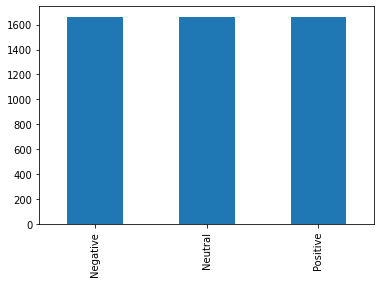

In [4]:
data["label"].replace({0: "Negative", 1: "Neutral", 2: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

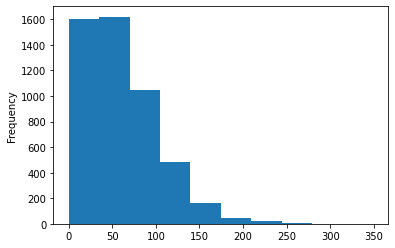

In [5]:
data["text"].str.len().plot.hist()

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data["text"])
sequences = tokenizer.texts_to_sequences(data["text"])

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

padded_data = pad_sequences(sequences, maxlen=100)

Found 15411 unique tokens.


In [7]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
labels = encoder.fit_transform(data["label"])
labels = to_categorical(labels, 3)

X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3991, 100) (3991, 3)
(998, 100) (998, 3)


In [9]:
with open("glove.4M.100d.txt", encoding="utf-8") as f:
    content = f.readlines()[1:]

In [10]:
import numpy as np

embeddings_index = dict()
for line in content:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs

In [11]:
vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(embedding_dim,), dtype="float32", name="review_input"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1541200   
                                                                 
 review_input (InputLayer)   multiple                  0         
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 100)               1000100   
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,544,631
Trainable params: 1,003,431
Non-

In [14]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
125/125 [==============================] - 3s 15ms/step - loss: 1.0400 - accuracy: 0.4583 - val_loss: 1.0417 - val_accuracy: 0.4589
Epoch 2/50
125/125 [==============================] - 1s 9ms/step - loss: 0.8289 - accuracy: 0.6342 - val_loss: 1.0735 - val_accuracy: 0.4760
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 0.6338 - accuracy: 0.7387 - val_loss: 1.1517 - val_accuracy: 0.4780
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 0.4506 - accuracy: 0.8276 - val_loss: 1.4504 - val_accuracy: 0.4699
Epoch 5/50
125/125 [==============================] - 1s 9ms/step - loss: 0.3010 - accuracy: 0.9003 - val_loss: 1.6471 - val_accuracy: 0.4699
Epoch 6/50
125/125 [==============================] - 1s 10ms/step - loss: 0.1864 - accuracy: 0.9439 - val_loss: 1.9323 - val_accuracy: 0.4529


In [15]:
from datetime import datetime

model.save(f"models/SA-GLOVE-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

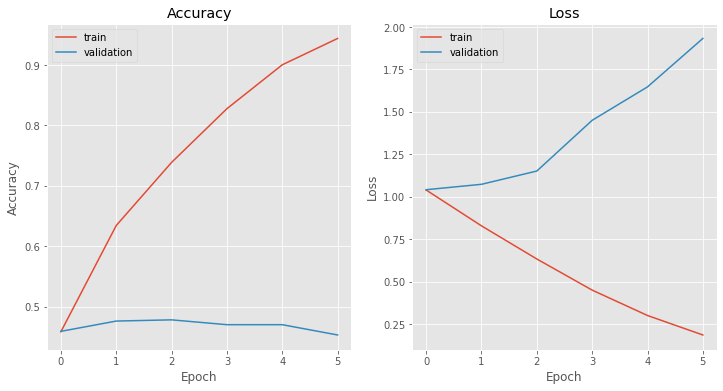

In [16]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [17]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

32/32 [==============================] - 0s 4ms/step - loss: 1.9323 - accuracy: 0.4529
Validation loss: 1.9322640895843506
Validation accuracy: 0.4529058039188385
